In [6]:
path = "MyDrive/DSAIL"
def mount_drive():
  from google.colab import drive
  mount_location = '/content/drive'
  drive.mount(mount_location,force_remount=True)
  return mount_location
import os, sys
mount_location = mount_drive()
print("your google drive is mounted at: ", mount_location)
path = os.path.join(mount_location,path) # "/content/drive/MyDrive/"
if os.path.exists(path):
  print("Path exists\n\t", path)
  sys.path.append(path)
  print("Path added (file under this path automatically identified)\n\t", path)
  os.chdir(path)
else :
  raise ValueError("Path does not exist. Set proper path \n", path)

Mounted at /content/drive
your google drive is mounted at:  /content/drive
Path exists
	 /content/drive/MyDrive/DSAIL
Path added (file under this path automatically identified)
	 /content/drive/MyDrive/DSAIL


In [109]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from math import sqrt
import torchvision
from types import SimpleNamespace
from torchvision import transforms

config = SimpleNamespace(
    seed = 1,
    batch_size = 256,
    test_batch_size = 16,
    lr = 2e-4,
    epoch = 10,
    input_dim = 28 * 28,
    hidden_dim = 500,

)
# Check device is 'cuda' if GPU is available
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device

class dataloader(torch.utils.data.Dataset):
  def __init__(self,train=True, batch_size = 64):
    super(dataloader, self).__init__()
    self.batch_size = batch_size
    self.transform = transforms.Compose([ transforms.ToTensor()])
    self.dataset = torchvision.datasets.MNIST (root='./data',  transform=self.transform,  train=train, download=True)
    self.dataloader = torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=train, drop_last=True)
  def __len__(self):
    return len(self.dataloader)
  def __iter__(self):
    return iter(self.dataloader)
  def __getitem__(self, idx):
    return self.dataloader[idx]

train_loader = dataloader(train=True, batch_size=config.batch_size)
test_loader = dataloader(train=False, batch_size=config.batch_size)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_image(tensor_data, num_images=10):
    numpy_images = tensor_data[:num_images].detach().numpy()

    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    for i in range(num_images):
        axes[i].imshow(numpy_images[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()


In [110]:
class RBM(nn.Module):
  def __init__(self, config, train_loader = train_loader, test_loader = test_loader):
    super(RBM, self).__init__()
    '''
    RBM
    VAE처럼 visible -> hidden -> visible 이렇게 한 번만 거침

    '''
    self.input_dim = config.input_dim
    self.hidden_dim = config.hidden_dim
    self.epochs = config.epoch

    # Parameters
    self.b = nn.Parameter(torch.randn(self.input_dim)) # bias for visible layer
    self.c = nn.Parameter(torch.randn(self.hidden_dim)) # bias for hidden layer
    self.W = nn.Parameter(torch.randn(self.hidden_dim, self.input_dim)*1e-2)

    self.optimizer = optim.Adam(self.parameters(), lr = config.lr)

    self.train_loader = train_loader
    self.test_loader = test_loader

  def sampling(self, p):
    recommended_p = torch.rand(p.size())
    rejected_sampling = torch.where(p - recommended_p > 0, torch.tensor(1.0), torch.tensor(0.0))

    return rejected_sampling

  def v_to_h(self, v):
    # visible -> hidden
    # print("v", v.shape)
    hidden_layers = torch.sigmoid(torch.matmul(v, self.W.t()) + self.c) # (batch_size, hidden_dim)
    # sampling hidden
    sampled_h = self.sampling(hidden_layers)
    return sampled_h

  def h_to_v(self, h):
    # hidden -> visible
    visible = torch.sigmoid(torch.matmul(h, self.W) + self.b)
    sampled_v = self.sampling(visible)
    return sampled_v

  def forward(self, v):
    # 첫 번째 시작은 data point에서
    h = self.v_to_h(v)
    v_reconstructed = self.h_to_v(h)

    return h, v_reconstructed

  def free_energy(self, v):
    # -bv- sigma(log(1 + exp(c + wv)))
    # bv = torch.dot(v, self.b)
    bv = torch.matmul(v, self.b)
    log_term = torch.log(torch.exp(torch.matmul(v, self.W.t()) + self.c) + 1).sum(dim = 1)

    free_energy = (-bv - log_term).mean()
    # print("free_energy", free_energy)
    return free_energy

  def fit(self):
    train_loss = []
    for epoch in range(self.epochs):
      batch_loss = 0
      for data, labels in train_loader:
        data = (data.view(-1,784))
        self.optimizer.zero_grad()
        h, v_reconstructed = self.forward(data)
        loss = self.free_energy(data) - self.free_energy(v_reconstructed)
        batch_loss += (loss.item())
        loss.backward()
        self.optimizer.step()
        train_loss.append(loss.item())
      print(f"Train loss{ batch_loss / len(train_loader)}")
    return train_loss, v_reconstructed, data

Train loss-2.394446283324152
Train loss-4.7656749497112045
Train loss-1.6974955501719418
Train loss-0.34909683618790066
Train loss0.39403396997696316
Train loss0.8232922676282052
Train loss1.2271476810813968
Train loss1.4357271112947383
Train loss1.6249435294387686
Train loss1.8009493575136886


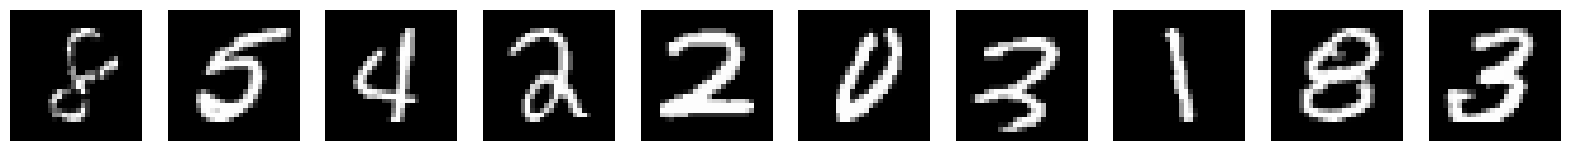

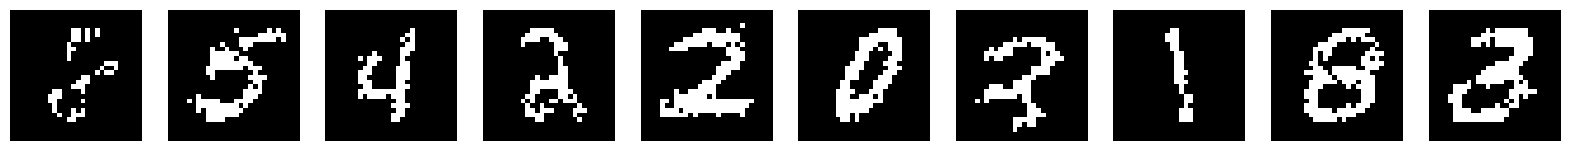

In [111]:
model = RBM(config)
train_loss, v_reconstructed, data  = model.fit()

data = data.view(-1, 1, 28, 28)
show_image(data)
v_reconstructed = v_reconstructed.view(-1, 1, 28, 28)
show_image(v_reconstructed)

# VAE vs RBM
 둘 다 parameter를 학습시켜서 결과론적으로 확률 분포를 모델링하는 것 같은데
 RBM이 rejected sampling처럼 hidden -> visible로 갈 때 정말 확률로 sampling 하는 느낌을 준다,,

 그럼에도 둘의 차이는...  뭐지???